In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 8, 30)

df = web.DataReader("ORAN", 'yahoo', start, end)
df.tail(),df.head()

(             High    Low   Open  Close    Volume  Adj Close
 Date                                                       
 2019-08-26  14.92  14.84  14.90  14.92  248000.0      14.92
 2019-08-27  14.96  14.87  14.94  14.87  275700.0      14.87
 2019-08-28  15.05  14.89  14.95  15.04  267000.0      15.04
 2019-08-29  15.24  15.11  15.23  15.15  513600.0      15.15
 2019-08-30  15.25  15.11  15.22  15.19  281200.0      15.19,
                  High        Low       Open      Close    Volume  Adj Close
 Date                                                                       
 2010-01-04  25.980000  25.770000  25.820000  25.910000  207400.0  13.432312
 2010-01-05  25.950001  25.760000  25.830000  25.820000  152200.0  13.385656
 2010-01-06  25.830000  25.629999  25.830000  25.709999  116300.0  13.328629
 2010-01-07  25.370001  25.209999  25.250000  25.299999  443300.0  13.116075
 2010-01-08  25.200001  24.969999  25.200001  25.170000  548300.0  13.048685)

In [2]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg.tail()

Date
2019-08-26    15.265038
2019-08-27    15.252152
2019-08-28    15.240869
2019-08-29    15.230201
2019-08-30    15.220030
Name: Adj Close, dtype: float64

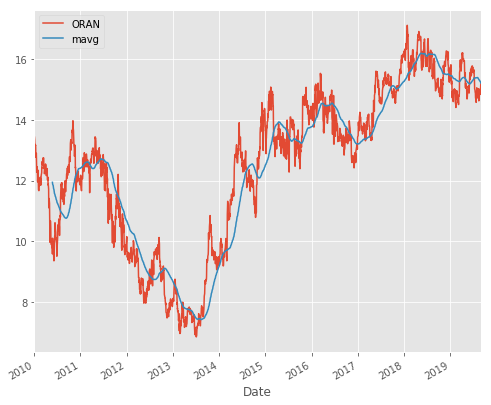

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='ORAN')
mavg.plot(label='mavg')
plt.legend()

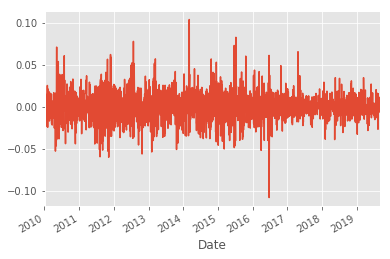

In [4]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [5]:
dfcomp = web.DataReader(['ORAN', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']
retscomp = dfcomp.pct_change()
corr = retscomp.corr()
print(corr)

Symbols        GE      GOOG       IBM      MSFT      ORAN
Symbols                                                  
GE       1.000000  0.332437  0.437855  0.361893  0.372269
GOOG     0.332437  1.000000  0.406329  0.538604  0.340483
IBM      0.437855  0.406329  1.000000  0.491927  0.378818
MSFT     0.361893  0.538604  0.491927  1.000000  0.382026
ORAN     0.372269  0.340483  0.378818  0.382026  1.000000


Text(0, 0.5, 'Returns GOOG')

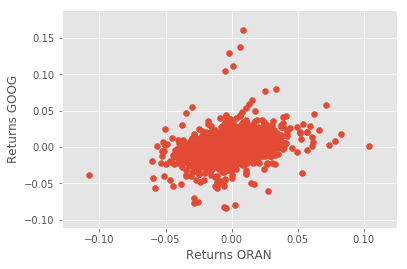

In [6]:
plt.scatter(retscomp.ORAN, retscomp.GOOG)
plt.xlabel('Returns ORAN')
plt.ylabel('Returns GOOG')

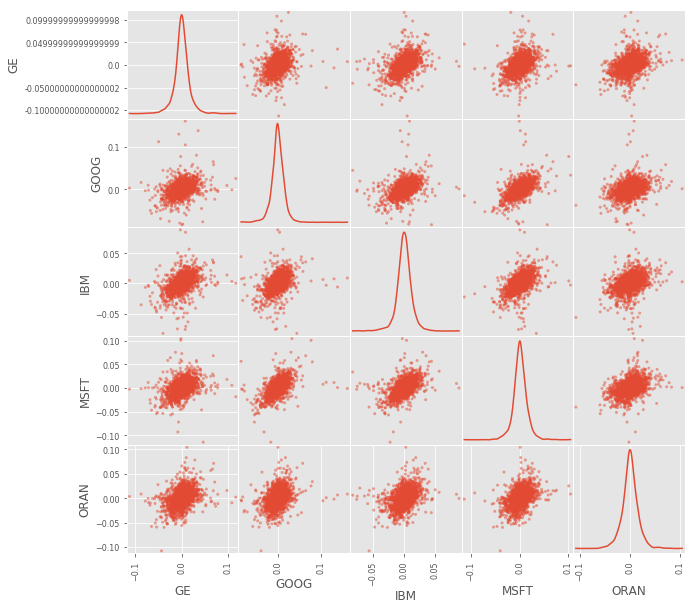

In [7]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

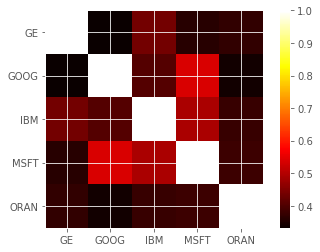

In [8]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

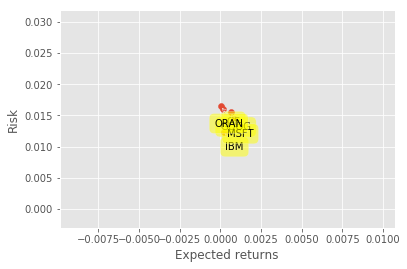

In [9]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [10]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [11]:
import math
import numpy as np
from sklearn import preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [12]:
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
X_train,X_test,y_train,y_test=train_test_split(X,y)
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [13]:
# KNN Regression
from sklearn.neighbors import KNeighborsRegressor
clfknn = KNeighborsRegressor(n_neighbors=10)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [14]:
# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor
clfrf = RandomForestRegressor(n_estimators=100,n_jobs=-1)
clfrf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [15]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
confidencerf = clfrf.score(X_test, y_test)
print("Results")
print('The linear regression confidence is ', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The quandratic RF regression confidence is ', confidencerf)

Results
The linear regression confidence is  0.9070581648273682
The quadratic regression 2 confidence is  0.9084202694497044
The quadratic regression 3 confidence is  0.8977567218436091
The RF regression confidence is  0.914278076635507


In [18]:
forecast_set = clfrf.predict(X_lately)
dfreg['Forecast'] = np.nan
print(forecast_set)

[15.02455635 14.46418948 14.50977096 14.63431263 14.27878979 14.36526898
 14.79188104 14.73701537 15.05653597 14.52313182 15.06055579 14.72341913
 14.62211519 14.28777555 14.13448372 15.28104546 15.2104705  15.22940126
 14.74579144 14.59720292 15.41369823 15.07996696 15.39626234 14.98876239
 15.03327547]


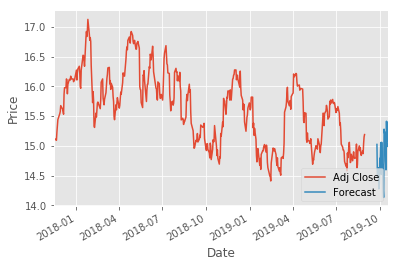

In [19]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
